In [3]:
import sys
from pathlib import Path

root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

In [4]:
from src.kaggle_utils import download_competition

data_dir = download_competition("playground-series-s5e11")
data_dir

PosixPath('/Users/boris.tsarev/MyProjects/kaggle-competitions/data/raw/playground-series-s5e11')

In [107]:
import pandas as pd

for file in Path(data_dir).iterdir():
    print(f"{file.name} - {file.stat().st_size} bytes")

data = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")

test.csv - 23021430 bytes
train.csv - 55988519 bytes
sample_submission.csv - 2291139 bytes


In [98]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=0.2)

# Look at the data

In [46]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
322259,322259,111037.11,0.116,735,29130.44,11.41,Female,Married,High School,Employed,Other,C1,1.0
413228,413228,36556.64,0.118,706,27167.76,13.36,Male,Married,High School,Unemployed,Debt consolidation,C1,0.0
207196,207196,122013.81,0.086,679,18665.90,13.69,Male,Single,High School,Self-employed,Car,C1,1.0
204359,204359,43948.63,0.074,775,6011.85,13.61,Male,Single,High School,Employed,Other,B2,1.0
149907,149907,39200.18,0.097,729,2687.91,12.16,Male,Single,Master's,Employed,Debt consolidation,C2,1.0


In [7]:
train.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [47]:
cats = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
conts = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
dep = 'loan_paid_back'

def proc_data(df):
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])

    df[cats] = df[cats].apply(lambda x: x.cat.codes)


pr_train = train.copy()
proc_data(pr_train)
pr_train.gender.head()

322259    0
413228    1
207196    1
204359    1
149907    1
Name: gender, dtype: int8

In [48]:
train_X = pr_train.drop(columns=['loan_paid_back'])
train_y = pr_train.loan_paid_back
train_X.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
322259,322259,111037.11,0.116,735,29130.44,11.41,0,1,1,0,6,10
413228,413228,36556.64,0.118,706,27167.76,13.36,1,1,1,4,2,10
207196,207196,122013.81,0.086,679,18665.90,13.69,1,2,1,2,1,10
204359,204359,43948.63,0.074,775,6011.85,13.61,1,2,1,0,6,6
149907,149907,39200.18,0.097,729,2687.91,12.16,1,2,2,0,2,11


# Decision Tree

In [49]:
pr_valid = valid.copy()
proc_data(pr_valid)

valid_X = pr_valid.drop(columns=['loan_paid_back'])
valid_y = pr_valid.loan_paid_back
valid_X.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
139988,139988,62911.26,0.068,626,21781.85,12.82,1,1,0,0,2,19
233460,233460,72337.81,0.071,658,12661.40,16.00,1,1,1,0,2,17
162922,162922,23606.50,0.072,653,9106.54,15.30,1,2,0,3,2,16
139478,139478,50471.50,0.242,691,5481.42,14.54,0,1,1,0,0,13
166561,166561,49857.72,0.079,667,14144.95,13.62,0,2,0,0,4,19


In [75]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(train_X, train_y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,4
,min_impurity_decrease,0.0
,class_weight,None


In [40]:
import graphviz

def draw_tree(model, X, size=10, ratio=0.6, precision=2):
    """Draw a decision tree using graphviz"""
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        precision=precision
    )
    graph = graphviz.Source(dot_data)
    return graph

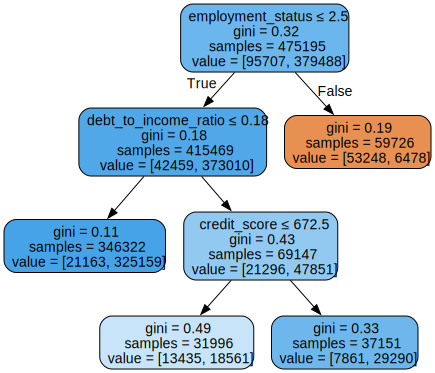

In [51]:
draw_tree(clf, train_X, size=10)

In [71]:
from sklearn.metrics import roc_auc_score

roc_auc_score(valid_y, clf.predict(valid_X))

0.7688676877483348

In [ ]:
def subm(df, preds, suff):
    df['loan_paid_back'] = preds
    sub_df = df[['id','loan_paid_back']]
    sub_df.to_csv(Path("playground-series-s5e11_1") / f'sub-{suff}.csv', index=False)

pr_test = test.copy()
proc_data(pr_test)
subm(pr_test, clf.predict(pr_test), 'tree-1')

## Get probabilities

In [ ]:
probabilities = clf.predict_proba(valid_X)[:, 1]
probabilities

array([0.93889213, 0.93889213, 0.10846198, ..., 0.93889213, 0.93889213,
       0.93889213], shape=(118799,))

In [72]:
roc_auc_score(valid_y, probabilities)

0.8535073075467969

In [70]:
pr_test = test.copy()
proc_data(pr_test)

subm(pr_test, clf.predict_proba(pr_test)[:, 1], 'tree-proba')

## Feature importances

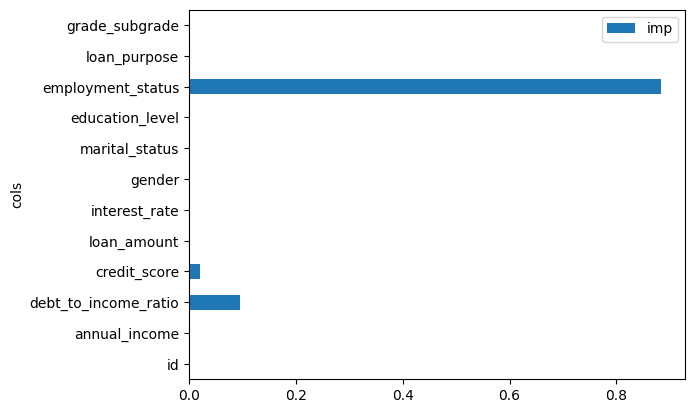

In [73]:
pd.DataFrame(dict(cols=train_X.columns, imp=clf.feature_importances_)).plot('cols', 'imp', 'barh');

## More leafes

In [76]:
clf = DecisionTreeClassifier(max_leaf_nodes=50)
clf.fit(train_X, train_y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,50
,min_impurity_decrease,0.0
,class_weight,None


In [81]:
probabilities = clf.predict_proba(valid_X)[:, 1]
roc_auc_score(valid_y, probabilities)

0.9083295426081339

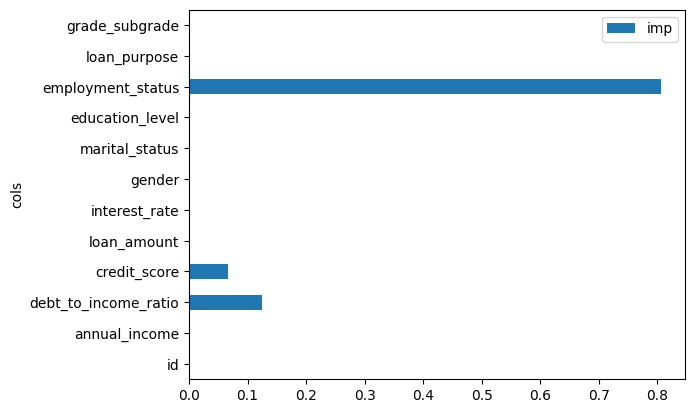

In [82]:
pd.DataFrame(dict(cols=train_X.columns, imp=clf.feature_importances_)).plot('cols', 'imp', 'barh');

In [84]:
pr_test = test.copy()
proc_data(pr_test)

subm(pr_test, clf.predict_proba(pr_test)[:, 1], 'tree-50')

# Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(train_X, train_y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [86]:
probabilities = rf.predict_proba(valid_X)[:, 1]
roc_auc_score(valid_y, probabilities)

0.9112235098134508

In [87]:
pr_test = test.copy()
proc_data(pr_test)

subm(pr_test, rf.predict_proba(pr_test)[:, 1], 'forest')

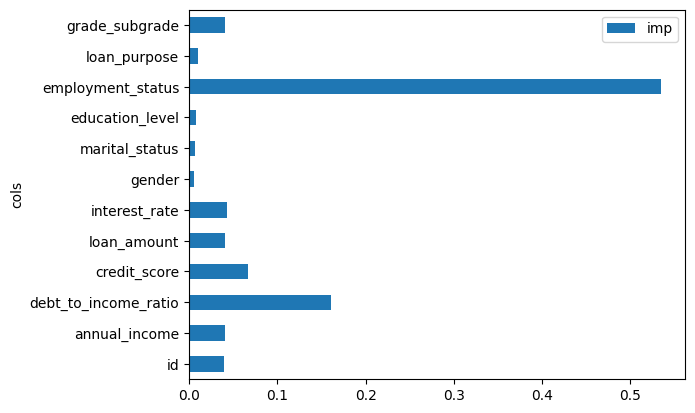

In [88]:
pd.DataFrame(dict(cols=train_X.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [91]:
train_X = pr_train.drop(columns=['loan_paid_back', 'id'])
train_y = pr_train.loan_paid_back
train_X.head()

valid_X = pr_valid.drop(columns=['loan_paid_back', 'id'])
valid_y = pr_valid.loan_paid_back
valid_X.head()

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(train_X, train_y)

probabilities = rf.predict_proba(valid_X)[:, 1]
roc_auc_score(valid_y, probabilities)

0.9111007766881112

# Feature Engineering

array([[<Axes: title={'center': 'loan_amount'}>,
        <Axes: title={'center': 'annual_income'}>]], dtype=object)

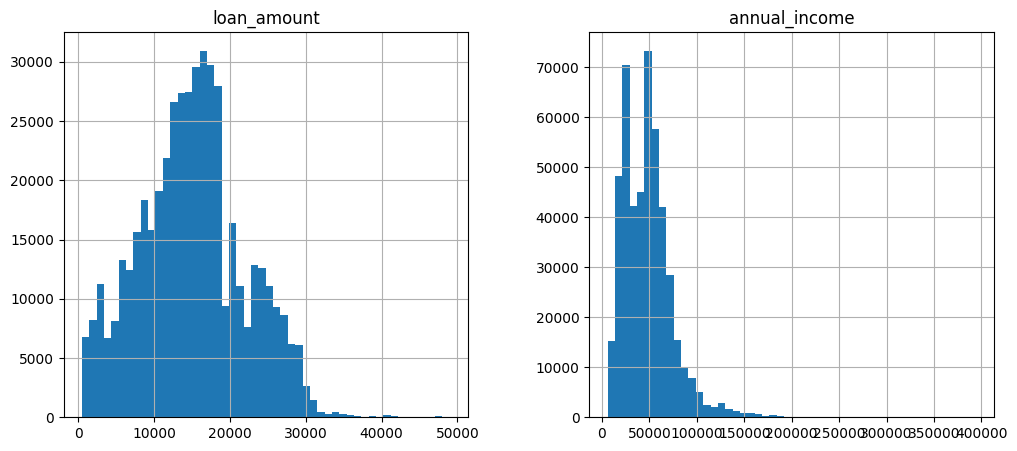

In [ ]:
train[['loan_amount', 'annual_income']].hist(figsize=(12, 5), bins=50)

array([[<Axes: title={'center': 'loan_amount_log'}>,
        <Axes: title={'center': 'annual_income_log'}>]], dtype=object)

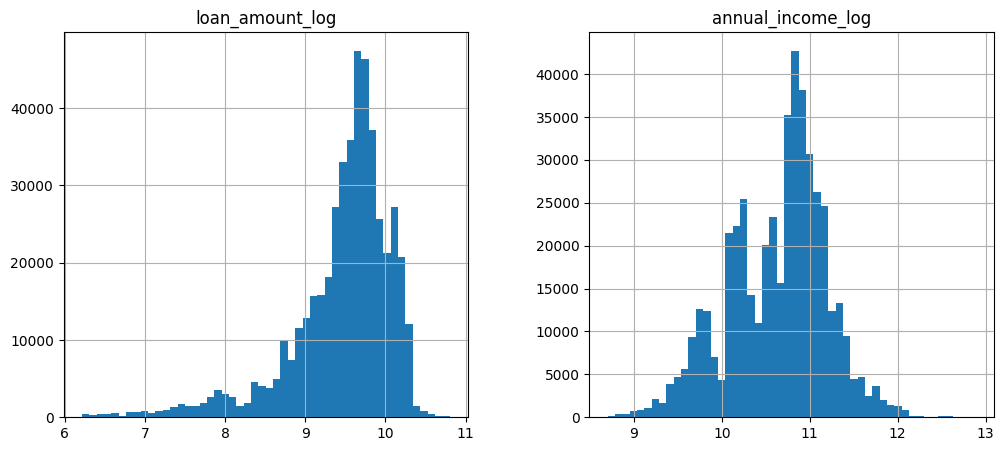

In [ ]:
import numpy as np

train_proc = train.copy()

train_proc['loan_amount_log'] = np.log1p(train_proc['loan_amount'])
train_proc['annual_income_log'] = np.log1p(train_proc['annual_income'])

train_proc[['loan_amount_log', 'annual_income_log']].hist(figsize=(12, 5), bins=50)

In [108]:
cats = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
conts = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
dep = 'loan_paid_back'

def proc_data(df):
    for cat in cats:
        df[cat] = pd.Categorical(df[cat])

    df[cats] = df[cats].apply(lambda x: x.cat.codes)
    df['loan_amount'] = np.log1p(train_proc['loan_amount'])
    df['annual_income'] = np.log1p(train_proc['annual_income'])


pr_train = train.copy()
proc_data(pr_train)

pr_valid = valid.copy()
proc_data(pr_valid)

train_X = pr_train.drop(columns=['loan_paid_back', 'id'])
train_y = pr_train.loan_paid_back

valid_X = pr_valid.drop(columns=['loan_paid_back', 'id'])
valid_y = pr_valid.loan_paid_back

pr_test = test.copy()
proc_data(pr_test)

In [109]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(train_X, train_y)

probabilities = rf.predict_proba(valid_X)[:, 1]
roc_auc_score(valid_y, probabilities)

0.9126298206620653

In [110]:
def predict_submit(model, suff):
    # Remove 'id' for prediction
    test_features = pr_test.drop(columns=['id'])
    
    # Get predictions
    preds = model.predict_proba(test_features)[:, 1]
    
    # Create submission DataFrame
    submission = pr_test[['id']].copy()
    submission['loan_paid_back'] = preds
    submission.to_csv(Path("playground-series-s5e11_1") / f'sub-{suff}.csv', index=False)

predict_submit(rf, 'forest-2')